In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping


In [3]:

# Load NVDA data
data = pd.read_csv("C:/Users/walaa/Downloads/NVDA.csv")
data['Date'] = pd.to_datetime(data['Date'])

# Filter from 2020-01-02
data = data[data['Date'] >= '2020-01-02'].reset_index(drop=True)

# Train/Test split (90%/10%)
train_size = int(len(data) * 0.9)
train_data = data[:train_size].copy()
test_data = data[train_size:].copy()

print(f"Total data points: {len(data)}")
print(f"Training data: {len(train_data)}")
print(f"Test data: {len(test_data)}")
print(f"Date range: {data['Date'].min()} to {data['Date'].max()}")

Total data points: 1288
Training data: 1159
Test data: 129
Date range: 2020-01-02 00:00:00 to 2025-02-14 00:00:00


In [4]:
# ===== NORMALIZE DATA =====
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data[['Adj Close']])
test_scaled = scaler.transform(test_data[['Adj Close']])

print(f"\nOriginal price range: ${train_data['Adj Close'].min():.2f} - ${train_data['Adj Close'].max():.2f}")
print(f"Scaled range: {train_scaled.min():.4f} - {train_scaled.max():.4f}")



Original price range: $4.89 - $135.56
Scaled range: 0.0000 - 1.0000


In [7]:
# ===== CREATE SEQUENCES =====
def create_sequences(data, n_steps=30):
    """
    Create sequences for LSTM/GRU training
    Args:
        data: normalized price data
        n_steps: number of time steps to look back
    Returns:
        X: input sequences (samples, time_steps, features)
        y: target values
    """
    X, y = [], []
    
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 0])
        y.append(data[i, 0])
    
    X, y = np.array(X), np.array(y)
    
    # Reshape X to (samples, time_steps, features)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    return X, y

# Create sequences
n_steps = 30  # Use 30 days to predict next day
print(f"\nCreating sequences with {n_steps} time steps...")

X_train, y_train = create_sequences(train_scaled, n_steps)

# For test data, we need to include last n_steps from training
combined_data = np.concatenate([train_scaled, test_scaled], axis=0)
X_test, y_test = create_sequences(combined_data[-(len(test_data) + n_steps):], n_steps)

print(f"Training sequences: {X_train.shape}")
print(f"Training targets: {y_train.shape}")
print(f"Test sequences: {X_test.shape}")
print(f"Test targets: {y_test.shape}")


Creating sequences with 30 time steps...
Training sequences: (1129, 30, 1)
Training targets: (1129,)
Test sequences: (129, 30, 1)
Test targets: (129,)


In [8]:
# ===== MODEL 1: LSTM =====

lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(n_steps, 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

lstm_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

print(lstm_model.summary())

# Train LSTM
print("\nTraining LSTM...")
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Predict with LSTM
lstm_pred_scaled = lstm_model.predict(X_test, verbose=0)
lstm_pred = scaler.inverse_transform(lstm_pred_scaled)

# Calculate metrics
actual_prices = test_data['Adj Close'].values
lstm_rmse = np.sqrt(mean_squared_error(actual_prices, lstm_pred))
lstm_mae = mean_absolute_error(actual_prices, lstm_pred)
lstm_mape = np.mean(np.abs((actual_prices - lstm_pred.flatten()) / actual_prices)) * 100

print(f"\n LSTM Results:")
print(f"   RMSE: ${lstm_rmse:.2f}")
print(f"   MAE: ${lstm_mae:.2f}")
print(f"   MAPE: {lstm_mape:.2f}%")

c:\Users\walaa\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

None

Training LSTM...
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0083 - mae: 0.0610 - val_loss: 0.0059 - val_mae: 0.0608
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.4775e-04 - mae: 0.0194 - val_loss: 0.0083 - val_mae: 0.0727
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.6145e-04 - mae: 0.0158 - val_loss: 0.0044 - val_mae: 0.0539
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.6462e-04 - mae: 0.0148 - val_loss: 0.0076 - val_mae: 0.0679
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.7169e-04 - mae: 0.0147 - val_loss: 0.0092 - val_mae: 0.0743
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.4356e-04 - mae: 0.0146 - val_loss: 0.0091 - val_mae: 0.0732
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.9534e-04 - mae: 0.0130 - val_loss: 0.0135 - val_mae: 0.0918
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.3552e-04 - mae: 0.0122 - val_loss: 0.0096 - val_mae: 0.0754
Epoch 9/50
32

In [9]:


# ===== MODEL 2: GRU =====
print("\n" + "=" * 60)
print("Building GRU Model")
print("=" * 60)

gru_model = Sequential([
    GRU(units=50, return_sequences=True, input_shape=(n_steps, 1)),
    Dropout(0.2),
    GRU(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

gru_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

print(gru_model.summary())

# Train GRU
print("\nTraining GRU...")
gru_history = gru_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

# Predict with GRU
gru_pred_scaled = gru_model.predict(X_test, verbose=0)
gru_pred = scaler.inverse_transform(gru_pred_scaled)

# Calculate metrics
gru_rmse = np.sqrt(mean_squared_error(actual_prices, gru_pred))
gru_mae = mean_absolute_error(actual_prices, gru_pred)
gru_mape = np.mean(np.abs((actual_prices - gru_pred.flatten()) / actual_prices)) * 100

print(f"\n GRU Results:")
print(f"   RMSE: ${gru_rmse:.2f}")
print(f"   MAE: ${gru_mae:.2f}")
print(f"   MAPE: {gru_mape:.2f}%")






Building GRU Model


c:\Users\walaa\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,551 (95.90 KB)

 Trainable params: 24,551 (95.90 KB)

 Non-trainable params: 0 (0.00 B)

None

Training GRU...
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0071 - mae: 0.0602 - val_loss: 0.0016 - val_mae: 0.0313
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 5.3987e-04 - mae: 0.0162 - val_loss: 0.0015 - val_mae: 0.0296
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 4.2271e-04 - mae: 0.0140 - val_loss: 0.0019 - val_mae: 0.0340
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 4.7014e-04 - mae: 0.0133 - val_loss: 0.0014 - val_mae: 0.0289
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.7062e-04 - mae: 0.0127 - val_loss: 0.0015 - val_mae: 0.0300
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.6430e-04 - mae: 0.0125 - val_loss: 0.0016 - val_mae: 0.0312
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.5595e-04 - mae: 0.0105 - val_loss: 0.0016 - val_mae: 0.0306
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.9547e-04 - mae: 0.0115 - val_loss: 0.0014 - val_mae: 0.0281
Epoch 9/50
32/

Model     RMSE      MAE  MAPE (%)
  GRU 5.141976 3.995491  3.098581
 LSTM 7.388320 5.926586  4.640090

 Best Model: GRU
   RMSE: $5.14
   MAE: $4.00
   MAPE: 3.10%


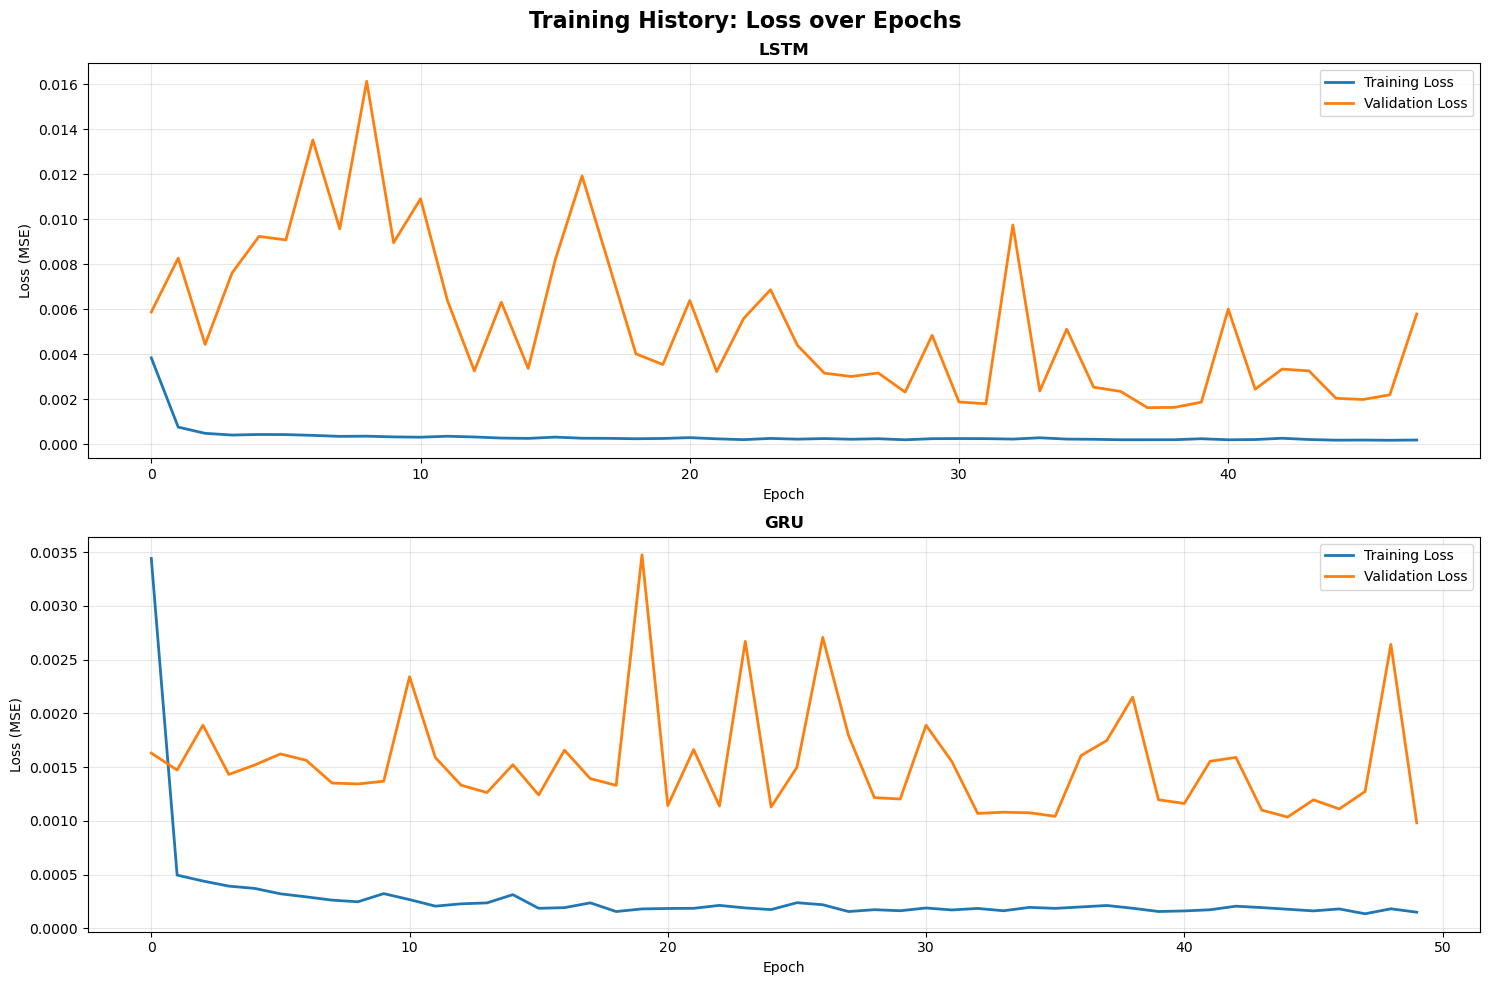

In [15]:
# ===== MODEL COMPARISON =====

comparison = pd.DataFrame({
    'Model': ['LSTM', 'GRU'],
    'RMSE': [lstm_rmse, gru_rmse],
    'MAE': [lstm_mae, gru_mae],
    'MAPE (%)': [lstm_mape, gru_mape]
})

comparison = comparison.sort_values('RMSE').reset_index(drop=True)
print(comparison.to_string(index=False))

best_model = comparison.iloc[0]['Model']
print(f"\n Best Model: {best_model}")
print(f"   RMSE: ${comparison.iloc[0]['RMSE']:.2f}")
print(f"   MAE: ${comparison.iloc[0]['MAE']:.2f}")
print(f"   MAPE: {comparison.iloc[0]['MAPE (%)']:.2f}%")

# ===== VISUALIZATIONS =====


#  Training History
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
fig.suptitle('Training History: Loss over Epochs', fontsize=16, fontweight='bold')

histories = [
    (lstm_history, 'LSTM'),
    (gru_history, 'GRU'),
    
]

for idx, (history, name) in enumerate(histories):
    ax = axes[idx]
    ax.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss (MSE)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

✅ Saved: predictions_comparison.png


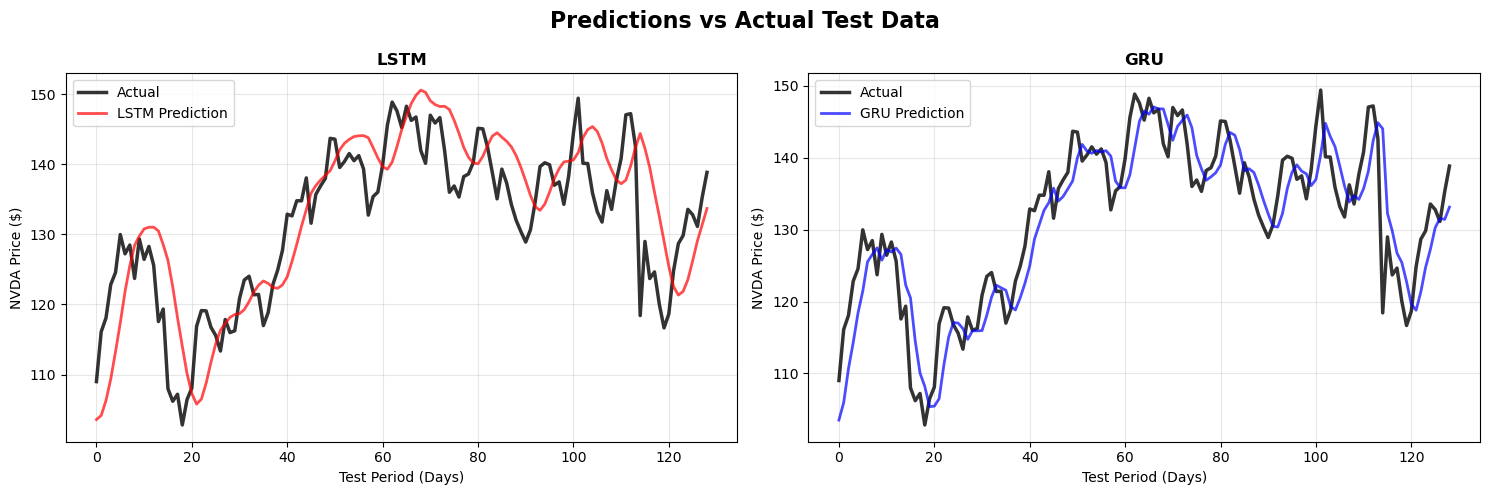

✅ Saved: all_models_comparison.png


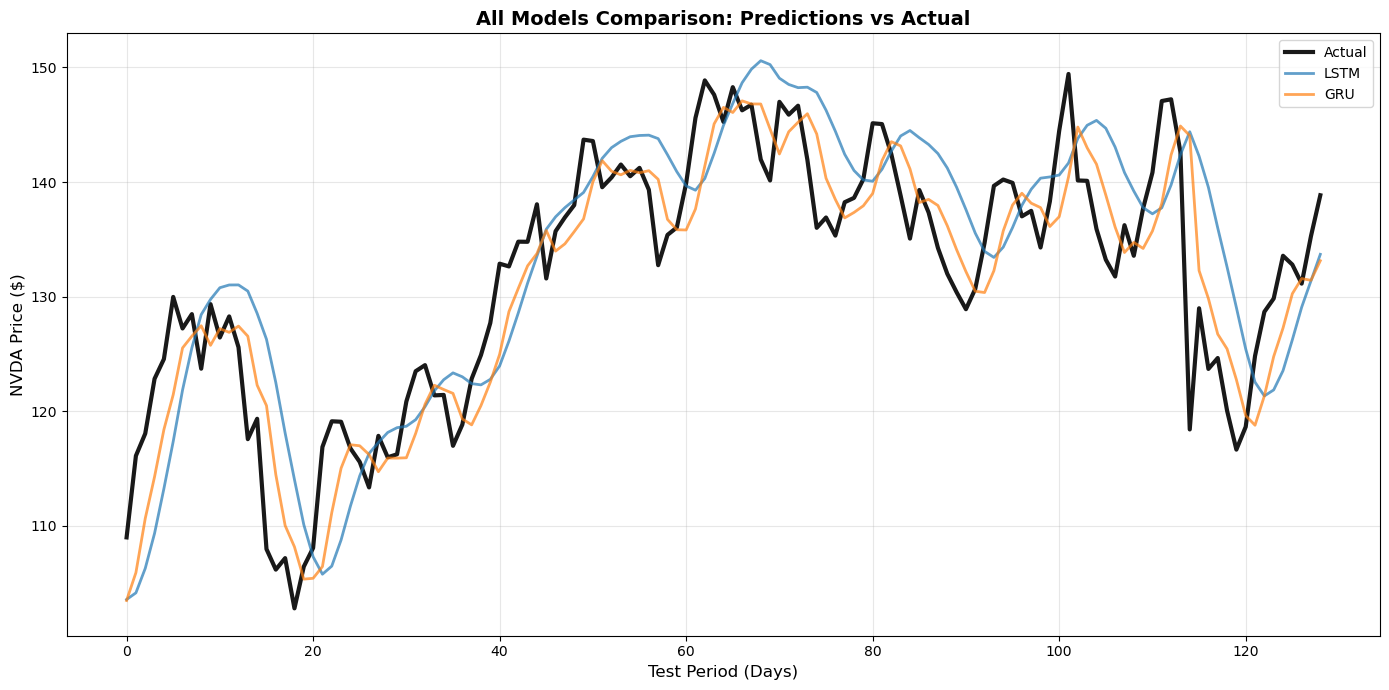

In [ ]:
# Plot 2: Predictions vs Actual
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Predictions vs Actual Test Data', fontsize=16, fontweight='bold')

predictions = [
    (lstm_pred, 'LSTM', 'red'),
    (gru_pred, 'GRU', 'blue'),
    
]

for idx, (pred, name, color) in enumerate(predictions):
    ax = axes[idx]
    ax.plot(actual_prices, label='Actual', color='black', linewidth=2.5, alpha=0.8)
    ax.plot(pred, label=f'{name} Prediction', color=color, linewidth=2, alpha=0.7)
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Test Period (Days)')
    ax.set_ylabel('NVDA Price ($)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot 3: All Models on One Plot
plt.figure(figsize=(14, 7))
plt.plot(actual_prices, label='Actual', color='black', linewidth=3, alpha=0.9)
plt.plot(lstm_pred, label='LSTM', linewidth=2, alpha=0.7)
plt.plot(gru_pred, label='GRU', linewidth=2, alpha=0.7)

plt.title('All Models Comparison: Predictions vs Actual', fontsize=14, fontweight='bold')
plt.xlabel('Test Period (Days)', fontsize=12)
plt.ylabel('NVDA Price ($)', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




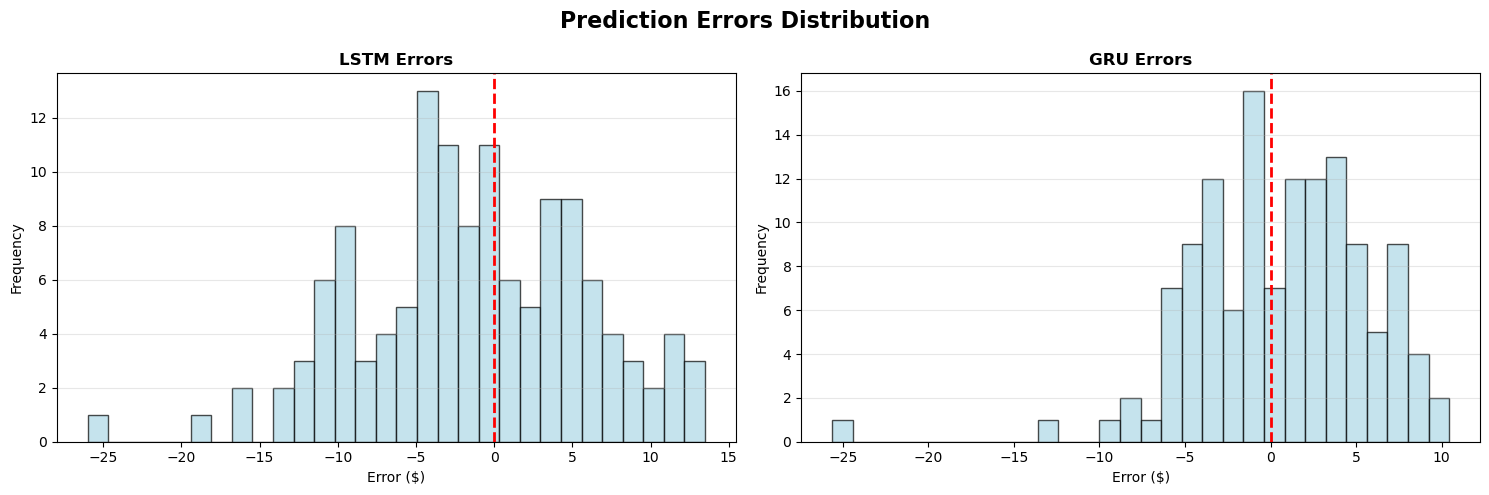

In [20]:
# Plot 4: Prediction Errors Distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Prediction Errors Distribution', fontsize=16, fontweight='bold')

errors = [
    (actual_prices - lstm_pred.flatten(), 'LSTM'),
    (actual_prices - gru_pred.flatten(), 'GRU')
]

for idx, (error, name) in enumerate(errors):
    ax = axes[idx]
    ax.hist(error, bins=30, color='lightblue', edgecolor='black', alpha=0.7)
    ax.axvline(x=0, color='red', linestyle='--', linewidth=2)
    ax.set_title(f'{name} Errors', fontsize=12, fontweight='bold')
    ax.set_xlabel('Error ($)')
    ax.set_ylabel('Frequency')
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


✅ Saved: metrics_comparison.png


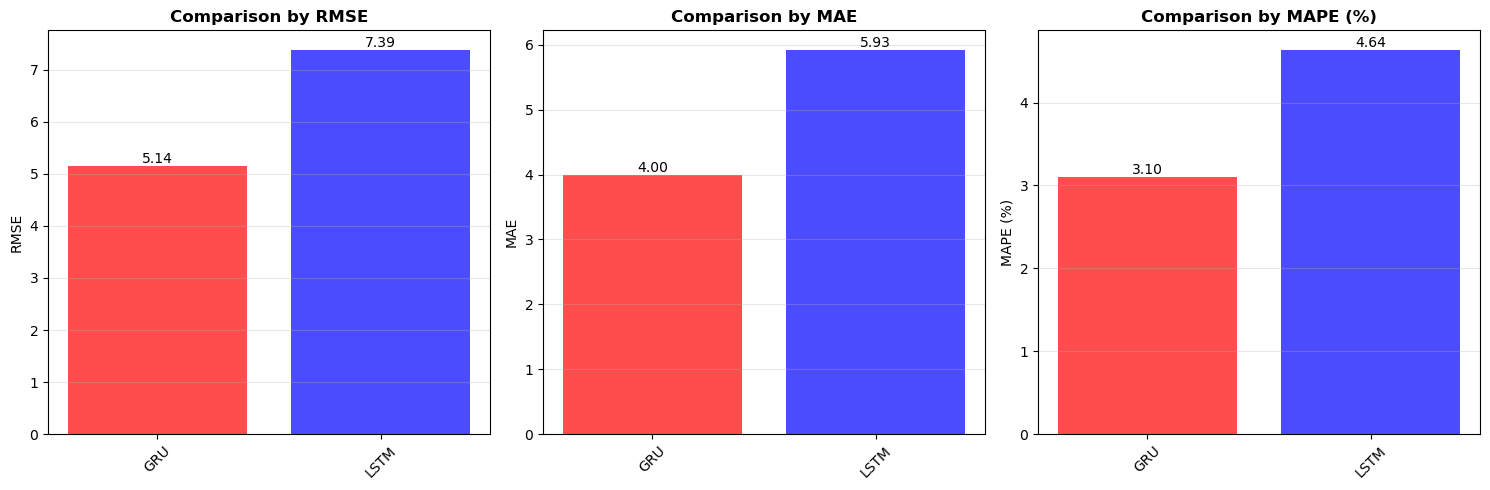


 Best performing model: GRU


In [ ]:
# Plot 5: Model Comparison Bar Chart
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['RMSE', 'MAE', 'MAPE (%)']
for idx, metric in enumerate(metrics):
    ax = axes[idx]
    bars = ax.bar(comparison['Model'], comparison[metric], 
                   color=['red', 'blue'], alpha=0.7)
    ax.set_title(f'Comparison by {metric}', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
print("\n Best performing model: " + best_model)